## Imports

In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from collections import Counter

## Code

In [2]:
fp_train = "tdt05-2021-challenge-2/challenge2_train.csv"
fp_test = "tdt05-2021-challenge-2/challenge2_test.csv"

In [3]:
df_train = pd.read_csv(fp_train)  # 81.488% False, 18.512% True
df_test = pd.read_csv(fp_test)

cleaned_df = df_train.copy(deep=True)

In [4]:
cleaned_df['f2'] = df_train['f2'].apply(lambda x: ord(x) - ord('a') if pd.notnull(x) else x)

In [5]:
cleaned_df['f5'] = df_train['f5'].apply(lambda x: None if x == -1 else x)
cleaned_df['f6'] = df_train['f6'].apply(lambda x: None if x == -1 else x)

### Alphabetical transformations

In [6]:
# F10 sin correlasjonsmatrise med løsningen indikerer at bokstaver har nær relasjon til de i nærheten alfabetisk.
# også i f13. Usikker om disse trenger å normaliseres.

f10 = df_train['f10'].apply(lambda x: ord(x) - ord('A') if pd.notnull(x) else x)
cleaned_df['f10'] = (f10 - f10.min())/(f10.max() - f10.min())

f13 = df_train['f13'].apply(lambda x: ord(x) - ord('a') if pd.notnull(x) else x)
cleaned_df['f13'] = (f13 - f13.min())/(f13.max() - f13.min())

# binary
cleaned_df['f20'] = df_train['f20'].apply(lambda x: (x//10)*2 + x%10 if pd.notnull(x) else x)
# f27 is the same as f20, droppit
cleaned_df.drop(['f27'], axis=1, inplace=True)

cleaned_df['f4'] = df_train['f4'].apply(lambda x: (x=='B')*1. if pd.notnull(x) else x)
cleaned_df['f25'] = df_train['f25'].apply(lambda x: (x=='T')*1. if pd.notnull(x) else x)
cleaned_df['f26'] = df_train['f26'].apply(lambda x: (x=='S')*1. if pd.notnull(x) else x)

cleaned_df['f22'] = df_train['f22'].replace({'R': 0, 'G': 1, 'B': 2})


cleaned_df['f18'] = df_train['f18'].apply(lambda x: ord(x) - ord('A') if pd.notnull(x) else x)
cleaned_df['f19'] = df_train['f19'].apply(lambda x: 10*x if pd.notnull(x) else x)


### HEX transforms

In [7]:
# F8
f8 = df_train['f8'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
cleaned_df['f8'] = (f8 - f8.min())/(f8.max() - f8.min())  # NORMALIZING

# F12
f12 = df_train['f12'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
cleaned_df['f12'] = (f12 - f12.min())/(f12.max() - f12.min())  # NORMALIZING

# F14
f14 = df_train['f14'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
cleaned_df['f14'] = (f14 - f14.min())/(f14.max() - f14.min())  # NORMALIZING

# F15
f15 = df_train['f15'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
cleaned_df['f15'] = (f15 - f15.min())/(f15.max() - f15.min())  # NORMALIZING

# F15
f23 = df_train['f23'].apply(lambda x: int(x, base=16) if pd.notnull(x) else x)
cleaned_df['f23'] = (f23 - f23.min())/(f23.max() - f23.min())  # NORMALIZING

In [8]:
# f1: Not really hex, but ok:
def ord_multi(x):
    '''
    Takes inn a string with two letters, takes ordinal of each and assumes base 26
    :param x: string of two letters, can be both cap an low-case
    :return: float
    '''

    if pd.isnull(x):
        return x
    num = ord(x[0])
    if x[0].islower():
        num -= 6
    num = num * 52 # 26*2

    num += ord(x[1])
    if x[1].islower():
        num -= 6
    return num

f1 = df_train['f1'].apply(ord_multi)
cleaned_df['f1'] = (f1 - f1.min())/(f1.max() - f1.min()) # Normalized

# Distribution operations

In [39]:
# f11 seems normally distributed. Could be an idea to push onto uniform
cleaned_df['f11'] = (df_train['f11'] - df_train['f11'].min())/(df_train['f11'].max() - df_train['f11'].min())

cleaned_df['f16'] = df_train['f16'] - df_train['f16'].min()

#f17: long tail distribution. Do quantile binning
f17 = np.log(df_train['f17'])
cleaned_df['f17'] = (f17 - f17.min())/(f17.max() - f17.min())

# f28: normally distributed.
cleaned_df['f28'] = (df_train['f28'] - df_train['f28'].min())/(df_train['f28'].max() - df_train['f28'].min())

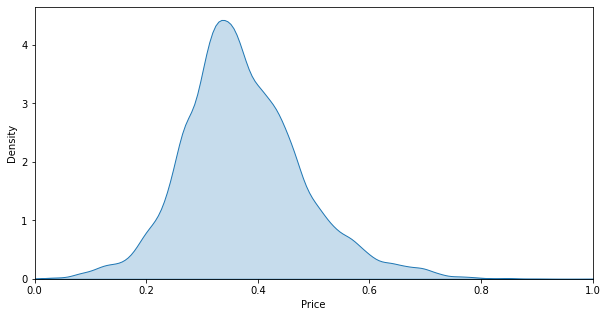

In [41]:
# Density exploring
col = f1  # df_train['f28']# .apply(lambda x: None if x == -1 else x)
x = cleaned_df['f17'] #(col - col.min())/(col.max() - col.min())
plt.figure(figsize=(10,5))
plt.xlim(0,1)
plt.xlabel('Price')
plt.ylabel('Density')
sns.kdeplot(x,shade=True)
plt.show()

df_train[['f19', 'f18']].value_counts(sort=0, normalize=True)*100

## Features

Categorical:
f9: 5 farger kan evt konvertere til tre features med 1/0 i rgb kolonner
f22: 3 farger

Numerical:
f5: 12
f8: continuous
f10: 26
f11: continuous
f12: continuous
f13: 26
f14: continuous
f15 continuous but weird distribution
f17: long-tail
f23: cont
f24 continuous but weird distribution
f1: cont, but words converted to their ordinal encoding

Both:
f0 : 2
f3: 3
f4 : 2
f6: 2
f7: 6
f18: 6, a-f men ikke noe lineært der. Nesten helt lik fordeling og targetinntrykk som f19
f19: 6, a-f men ikke noe lineært der. Nesten helt lik fordeling og targetinntrykk som f18
f20: 4,
f21: 7
f22: 3
f25: 2 TF
f26: 2 S/N

TOSS:
f27 is the same as f20. Toss one of them.


TODO:
f9

rgb

1,0,0
0,1,0
1,1,1
0,0,0
1,1,0

In [25]:
cleaned_df.iloc[:5, 10:20]

,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17
0,0.590215,yellow,0.08,0.234947,0.108895,0.500000,0.088004,0.470652,1.0,3.0
1,0.625974,green,0.00,0.291058,0.362094,0.428571,0.334158,0.114032,NaN,0.0
2,0.648969,white,0.28,0.484297,0.942573,0.142857,0.680349,0.717129,2.0,1.0
3,0.085286,yellow,0.40,0.120424,0.337501,0.142857,0.526789,0.649460,4.0,NaN
4,0.702688,yellow,0.96,0.501600,0.334802,0.000000,0.192889,0.470652,1.0,0.0


In [12]:
df_train['f9'].value_counts()

red       13429
white     11704
green      9169
yellow     7963
black      6246
Name: f9, dtype: int64

In [13]:
df_train['f22'].replace({'R': 0, 'G': 1, 'B': 2})

0        0.0
1        NaN
2        1.0
3        1.0
4        2.0
        ... 
49995    0.0
49996    0.0
49997    1.0
49998    0.0
49999    1.0
Name: f22, Length: 50000, dtype: float64

In [14]:
cleaned_df.to_csv('engineered_data.csv')

In [53]:
X_tr, X_vl = train_test_split(cleaned_df.drop(['id', 'target', 'f9'], axis=1), test_size=0.1, random_state=0)
Y_tr, Y_vl = train_test_split(cleaned_df['target'], test_size=0.1, random_state=0)

counter = Counter(cleaned_df['target'])
imbalancedness = counter[0] / counter[1]
print(f'Imbalanced by: {imbalancedness}')

Imbalanced by: 4.4019014693172


In [54]:
clf = xgb.XGBClassifier(objective="binary:logistic", random_state=0, scale_pos_weight=imbalancedness)
# clf.fit(X_tr, Y_tr)

In [56]:
y_pred = clf.predict(X_vl)
print(confusion_matrix(y_pred=y_pred, y_true=Y_vl))


NotFittedError: need to call fit or load_model beforehand

In [49]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(clf, X_tr, Y_tr, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.72247


In [55]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(clf, X_tr, Y_tr, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

Mean ROC AUC: 0.71809


In [60]:
clf.fit(X_tr, Y_tr, verbose=True)
y_pred = clf.predict(X_vl)
print(confusion_matrix(y_pred=y_pred, y_true=Y_vl))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:56:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[3122  927]
 [ 434  517]]
